In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.xticks([]), plt.yticks([])
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.tight_layout()
    plt.show()

In [2]:
import numpy as np
import cv2

# trs, let's assume width is always wider than height
def video_to_npy(infile, outfile=None, width=None, height=None, squarecrop=None, fps=None):
    vidcap = cv2.VideoCapture(infile)
    success, image = vidcap.read()
    frames = []
    count = 0
    
    if not success:
        raise ValueError('Could not read the video file!')
    
    while success:
        frames.append(image)
        count += 1
        success,image = vidcap.read()
    if fps:
        span = int(vidcap.get(cv2.CAP_PROP_FPS) / fps)
        frames = frames[0::span]
    if width or height:  
        width = width if width else int(height / frames[0].shape[0] * frames[0].shape[1])
        height = height if height else int(width / frames[0].shape[1] * frames[0].shape[0])
        frames = [ cv2.resize(frame, (width, height)) for frame in frames ]
    if squarecrop:
        
        tl = int((width/2)-(height/2))
        
        #import pdb; pdb.set_trace()
        # note that x,y is the wrong way around i.e. it's
        # F x Y x X x C
        frames = [ frame[ 0:height, tl:(tl+height)] for frame in frames ]
    frames = np.array(frames)
    if outfile:
        np.save(outfile, frames)
    return frames

In [133]:
import keras
from keras.applications import Xception

conv_base = Xception(include_top=False, 
                     weights='imagenet', 
                     input_shape=(299, 299, 3), 
                     pooling=None)

#note this outputs a 10, 10, 2048

conv_base.summary()

83689472/83683744 [==============================] - 24s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________

(84, 299, 299, 3)


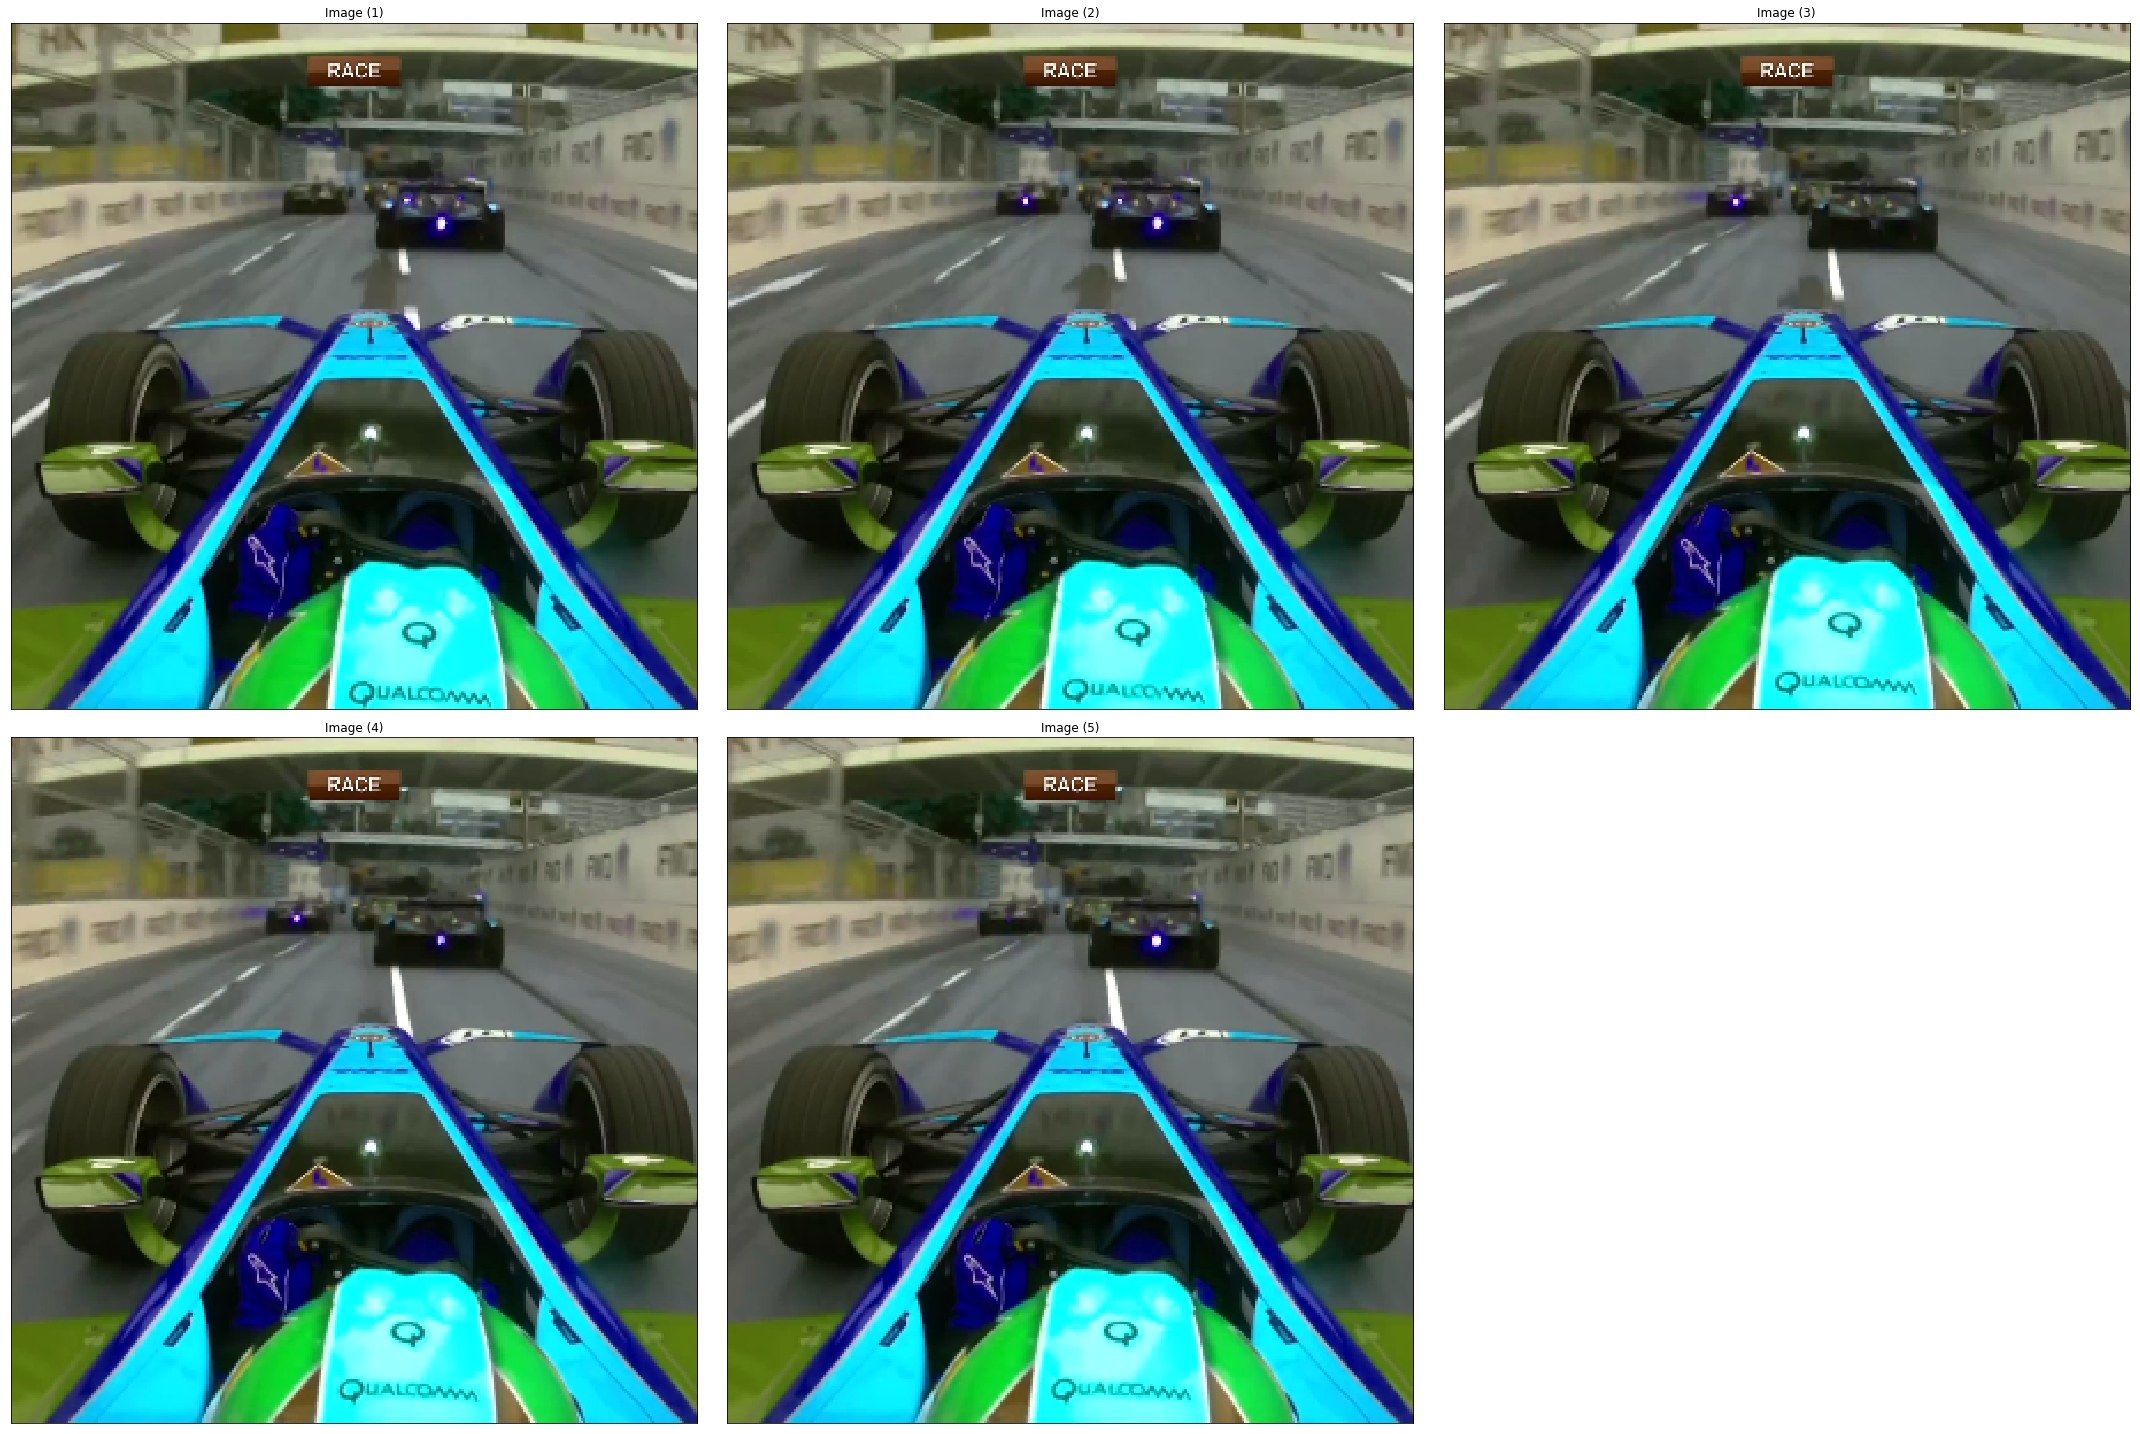

Wall time: 1.45 s


In [135]:
%%time
video_origin = video_to_npy('./videos-formula-collisions/collisions/output011-26961.mp4', 'test25.npy', height=299, squarecrop=1, fps=25)
print(video_origin.shape)

show_images(video_origin[:5], 2)

Take this video and compute embeddings for each frame using VGG and imagenet, then image plot the result

(84, 204800)


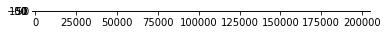

In [136]:
# compute embeddings
embeddings = conv_base.predict(video_origin)

# we are assmuming this is doing what we expect 
rembeddings = embeddings.reshape(84, 10*10*2048)

# now we have one 2048 embedding for each frame in the video!
print( rembeddings.shape )

plt.imshow(rembeddings)



Key ideas
=========

* We need our video features to be fixed time between frames
* We will transform frames into embeddings from a standard architecture trained on ImageNet
* We want to have the largest possible training set size i.e. we can transform one video into many videos by selecting different frames X frames apart
* We can augment our training data by randomly mutating the frames before computing an embedding vector for them

Assertions
=========

* The video features need to be fixed size, this may be achieved with zero padding


Get the lengths of all of the videos

In [71]:
from os import listdir
from os.path import isfile, join

def getLength(video, path):
    v = cv2.VideoCapture(join(path,video))
    v.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
    return int( v.get(cv2.CAP_PROP_POS_MSEC)/1000 )

def getVideoLengths(path):
    return map( lambda fp: (fp, getLength(fp, path) ), listdir(path) );


collision_len = list( getVideoLengths('videos-formula-collisions/collisions') )
ncollision_len = list( getVideoLengths('videos-formula-collisions/not-collisions') )

In [108]:
from itertools import chain, groupby

def howMany(vls):
    return list( map( lambda g: (g[0], len(list(g[1]))), 
              groupby( 
                  sorted( vls, key=lambda i: i[1]  ), 
                  lambda f: f[1] ) ) )

howMany( chain( collision_len, ncollision_len ) )
howMany(collision_len)
howMany(ncollision_len)

[(0, 5), (1, 46), (2, 46), (3, 24), (4, 22), (5, 47), (7, 2)]

Text(0.5,0,'Number of seconds')

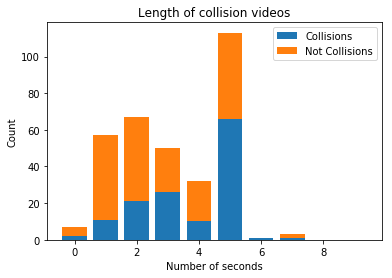

In [158]:
dc = dict(howMany(collision_len))
dnc = dict(howMany(ncollision_len))

colys = list( map( lambda i: dc[i] if i in dc else 0, range(0,10) ) )
colxs = list( map( lambda i: dnc[i] if i in dnc else 0, range(0,10) ) )

plt.bar(range(10), colys)
plt.bar(range(10), colxs, bottom=colys)
plt.legend(('Collisions', 'Not Collisions'))
plt.title('Length of collision videos')
plt.ylabel('Count')
plt.xlabel('Number of seconds')

How many collision videos are there

In [159]:
len(collision_len)

138

How many non collision videos are there?

In [160]:
len(ncollision_len)

192

There are 39% more non collision videos, let's assume there is one collision event in each video

In [162]:
len(ncollision_len) / len(collision_len)

1.391304347826087

ok now let's precompute Xs for both classes

In [21]:
from os import listdir
from os.path import isfile, join
import keras
from keras.applications import VGG
import numpy as np
import cv2

image_size = 299
max_secs = 8

conv_base = Xception(include_top=True, 
                     weights='imagenet', 
                     input_shape=(image_size, image_size, 3), 
                     pooling=None,
                     classes=1000)

conv_base.summary()

91889664/91884032 [==============================] - 32s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________

In [22]:
#precompute embeddings version

fps = 25

# the precomputed xdata structure gets passed in so fill in place
def extractVideo(path, xdata, index):
    v = video_to_npy(path, height=image_size, squarecrop=1, fps=fps)
    embeddings = conv_base.predict(v)
    rembeddings = embeddings.reshape(embeddings.shape[0], 1000 )
    xdata[index, 0:rembeddings.shape[0], :]=rembeddings
    
def getVideoSignals(path):
    d = listdir(path)
    # 25fps * 8 seconds == 200 frames to model for fixed input
    # now we have videos X frames X 2048, we need to put into a zero padded np structure
    xdata = np.zeros( ( len(d), (max_secs*fps), 1000 ) )
    for fp in list(enumerate( d )):
        extractVideo(join(path,fp[1]), xdata, fp[0] )
    return xdata

xcrash = getVideoSignals('videos-formula-collisions/collisions')
xncrash = getVideoSignals('videos-formula-collisions/not-collisions')

X = np.concatenate( (xcrash, xncrash), axis=0)
y = np.concatenate( ( np.ones( xcrash.shape[0] ), np.zeros( xncrash.shape[0] ) ), axis=0 )

In [ ]:
%xmode Plain
%pdb on

from os import listdir
from os.path import isfile, join

#just videos version
fps = 25
image_size = 300
max_secs = 5

# the precomputed xdata structure gets passed in so fill in place
def extractVideo(path, xdata, index):
    v = video_to_npy(path, height=image_size, squarecrop=1, fps=fps)
    # we seem to have some videos which have more than 80 frames? how is this possible?
    
    # take the max seconds, or if the video is less than that, as many as we can
    xdata[index, 0:min(v.shape[0],fps*max_secs), :,:,:]=v[ 0:min(v.shape[0],fps*max_secs),:,:,: ]
    
def getVideoSignals(path):
    d = listdir(path)
    # now we have videos X frames X [flattened conv base], we need to put into a zero padded np structure
    xdata = np.zeros( ( len(d), (max_secs*fps), image_size, image_size, 3 ) )
    for fp in list(enumerate( d )):
        extractVideo(join(path,fp[1]), xdata, fp[0] )
    return xdata

xcrash = getVideoSignals('./collisions')
xncrash = getVideoSignals('./not-collisions')

X = np.concatenate( (xcrash, xncrash), axis=0)
y = np.concatenate( ( np.ones( xcrash.shape[0] ), np.zeros( xncrash.shape[0] ) ), axis=0 )

Exception reporting mode: Plain
Automatic pdb calling has been turned ON


MemoryError: 

> <ipython-input-4-0fd2721f8c95>(23)getVideoSignals()
     21     d = listdir(path)
     22     # now we have videos X frames X [flattened conv base], we need to put into a zero padded np structure
---> 23     xdata = np.zeros( ( len(d), (max_secs*fps), image_size, image_size, 3 ) )
     24     for fp in list(enumerate( d )):
     25         extractVideo(join(path,fp[1]), xdata, fp[0] )



In [39]:
xcrash=0
xncrash=0
X=0
y=0

In [23]:
import pickle
pickle.dump( xcrash, open( "X2.p", "wb" ) )
pickle.dump( xncrash, open( "Y2.p", "wb" ) )

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [30]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=30, batch_size=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 197, 32)           128032    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 194, 32)           4128      
_________________________________________________________________
flatten_10 (Flatten)         (None, 6208)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                124180    
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 21        
Total para

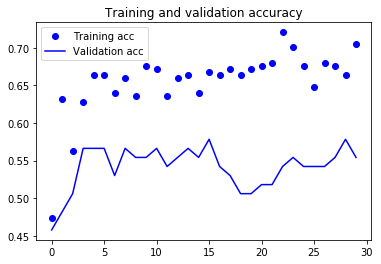

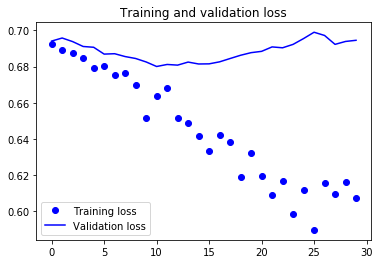

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()